# Hidden Markov Model
I plan to use a Hidden Markov model to predict streaming data in anomaly detection, then build a discriminator to tell where the anomalies are. <br>
https://en.wikipedia.org/wiki/Hidden_Markov_model <br>

In [124]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from hmmlearn import hmm

# Optional: run on all datasets:
path_all = [] 
directory = "Data/"
                                                                                                         
subdirs = [x[0] for x in os.walk(directory)]
for subdir in subdirs: 
    #print(subdir)
    for file in os.listdir(subdir):
        filename = os.fsdecode(file)
        if filename.endswith("csv"): 
            path_all.append(os.path.join(subdir,filename))
            continue
        else:
            continue

# plot path:
plot_path = "plots/"

#data path
root_path = "Data/realKnownCause/realKnownCause/"
df = pd.read_csv(root_path+'ambient_temperature_system_failure.csv')

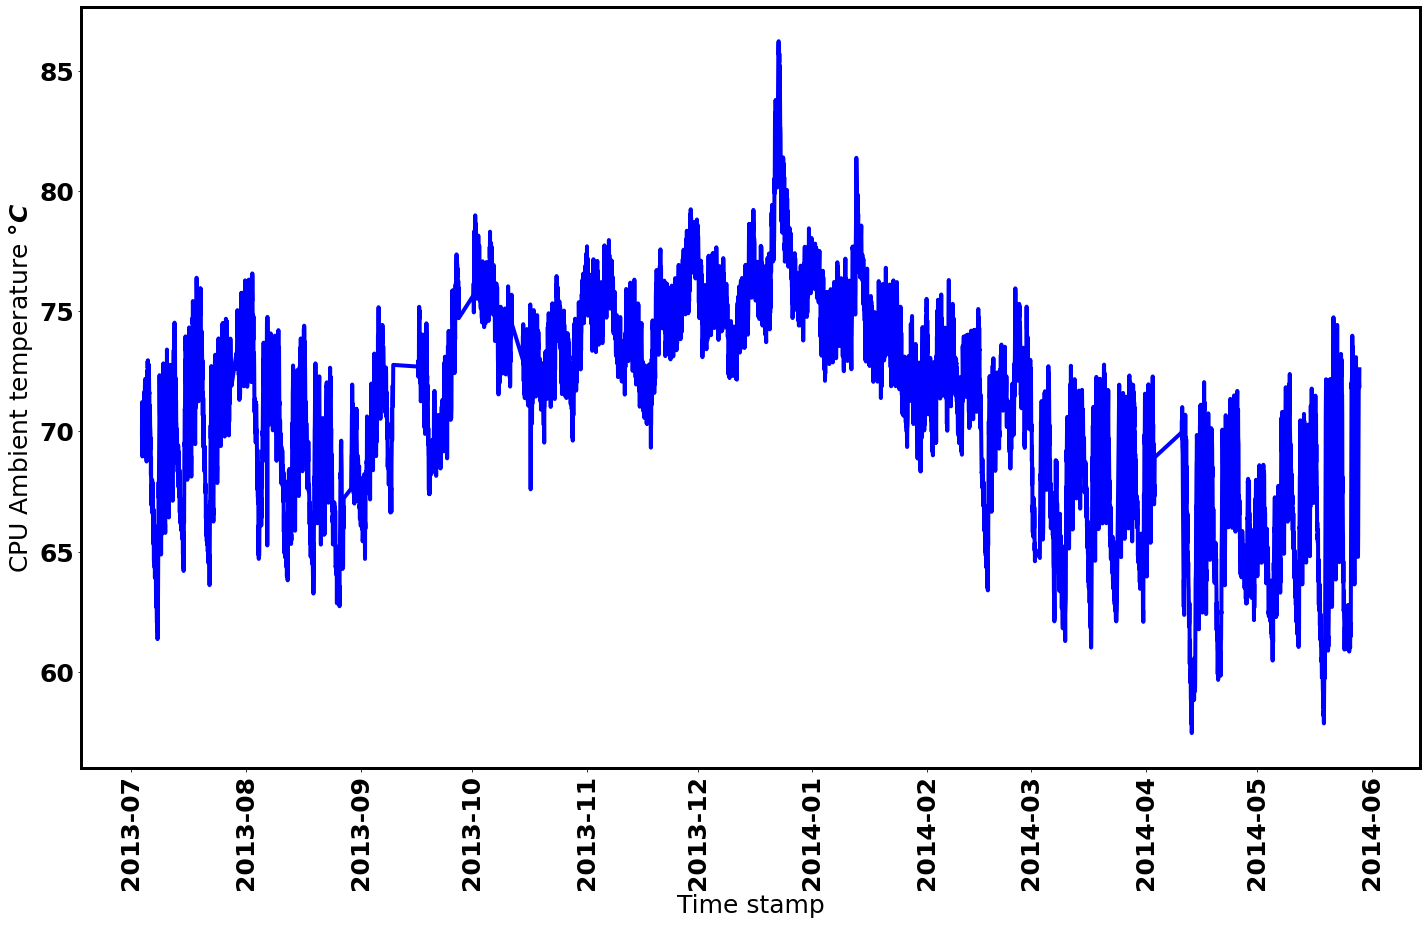

In [125]:
if True:
    # convert time stamp to numerical data
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    from matplotlib.pylab import rc
    font = {'family': 'normal','weight': 'bold',
            'size': 25}

    matplotlib.rc('font', **font)
    rc('axes', linewidth=3)


    # plot the data using Celcius
    #df.plot(x='timestamp', y='value')

    plt.plot(df['timestamp'],df['value'],"b",linewidth=4,markersize=5)
    #plt.plot(df['timestamp'],df['value'],"b",linewidth=4,markersize=5)

    plt.xlabel("Time stamp")
    plt.ylabel(r"CPU Ambient temperature $\degree C$")
    plt.xticks(rotation=90)
    fig = matplotlib.pyplot.gcf()


    fig.set_size_inches(24,14)




In [126]:
# convert to seconds
temp = df['timestamp'] - min(df['timestamp'])
temp = temp.dt.total_seconds().astype(int)

In [127]:
# 24*3600=86400
# compute high,low,open,close price: Similar to stock price:
# In future may spli by daylight and night

df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['days'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df["days_delta"] = temp//86400

df["open"]=None
df["close"]=None
df["low"]=None
df["high"]=None


In [128]:
import warnings
warnings.filterwarnings('ignore')
for d in range(df["days_delta"].max()+1):
    mask=df["days_delta"]==d
    value_d = list(df["value"][mask])
    if len(value_d)>0:
        df["open"][mask]=value_d[0]
        df["close"][mask]=value_d[-1]

        df["low"][mask]=min(value_d)
        df["high"][mask]=max(value_d)
    else:
        pass
print("Finish assigning values")

Finish assigning values


W0706 22:04:39.792038 140108444399424 legend.py:1247] No handles with labels found to put in legend.


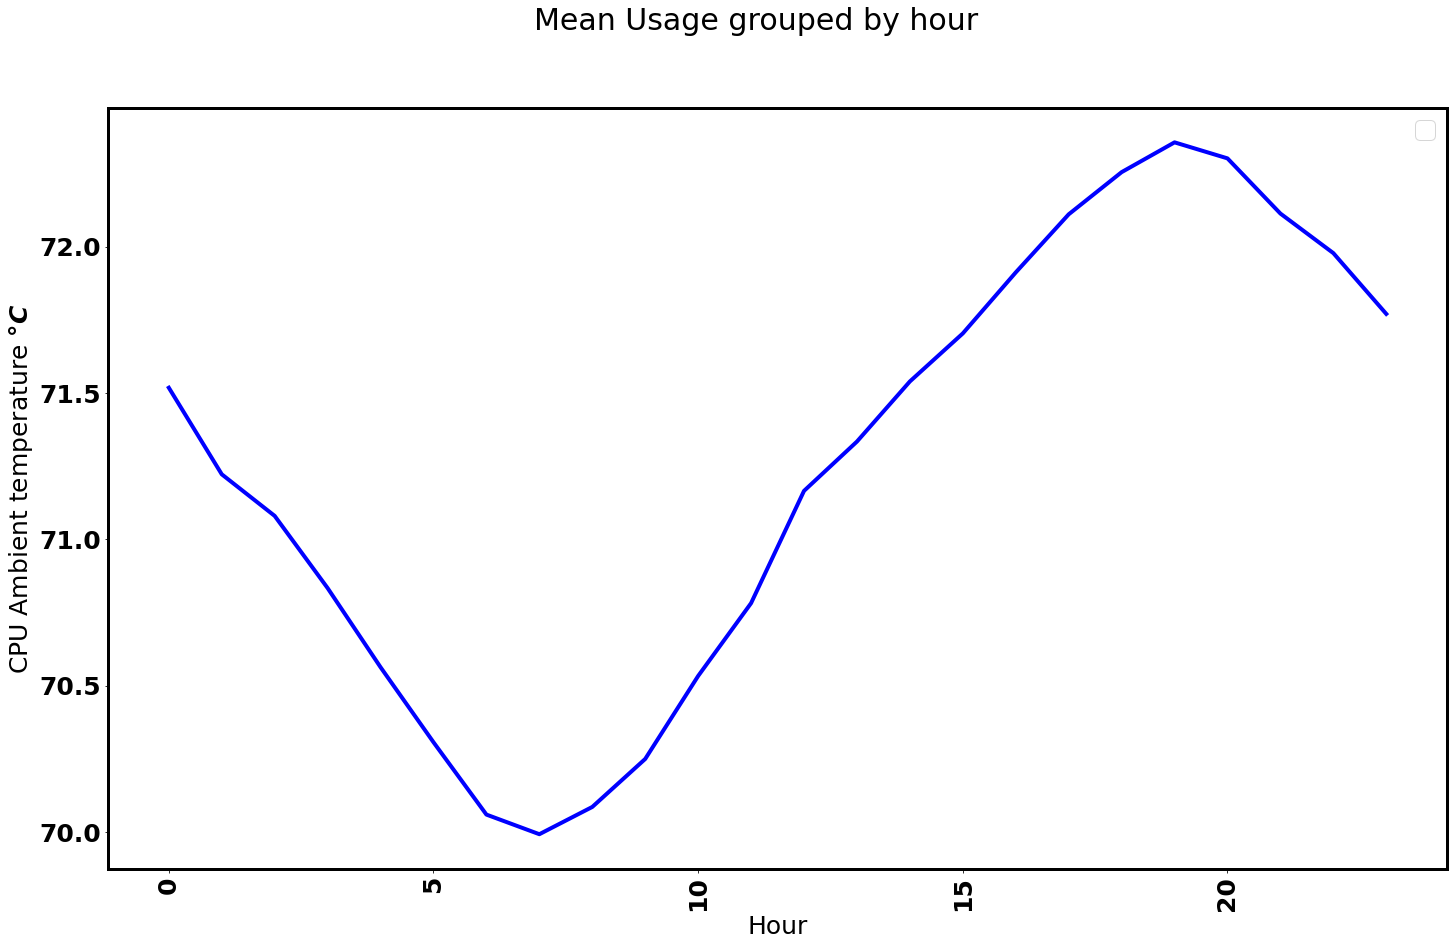

In [149]:
# Group by hours:
# df.groupby('hours').mean()
if True:
    # convert time stamp to numerical data
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    from matplotlib.pylab import rc
    font = {'family': 'normal','weight': 'bold',
            'size': 25}

    matplotlib.rc('font', **font)
    rc('axes', linewidth=3)


    # plot the data using Celcius
    #df.plot(x='timestamp', y='value')

    plt.plot(df.groupby('hours').mean().index,df.groupby('hours').mean()["value"],"b",linewidth=4,markersize=5)
    #plt.plot(df[df["daylight"]==0].groupby('hours').mean().index,df[df["daylight"]==0].groupby('hours').mean()["value"],"kx",linewidth=4,markersize=5,label="Night")
    #plt.plot(df[df["daylight"]==1].groupby('hours').mean().index,df[df["daylight"]==1].groupby('hours').mean()["value"],"rx",linewidth=4,markersize=5,label="Daylight")

    plt.xlabel("Hour")
    plt.ylabel(r"CPU Ambient temperature $\degree C$")
    plt.suptitle("Mean Usage grouped by hour")
    plt.xticks(rotation=90)
    fig = matplotlib.pyplot.gcf()


    fig.set_size_inches(24,14)
    plt.legend()

    save_path = plot_path + "Original_group_by_hour" + ".png"

    fig.savefig(save_path, dpi=300)





W0706 22:05:14.772250 140108444399424 legend.py:1247] No handles with labels found to put in legend.


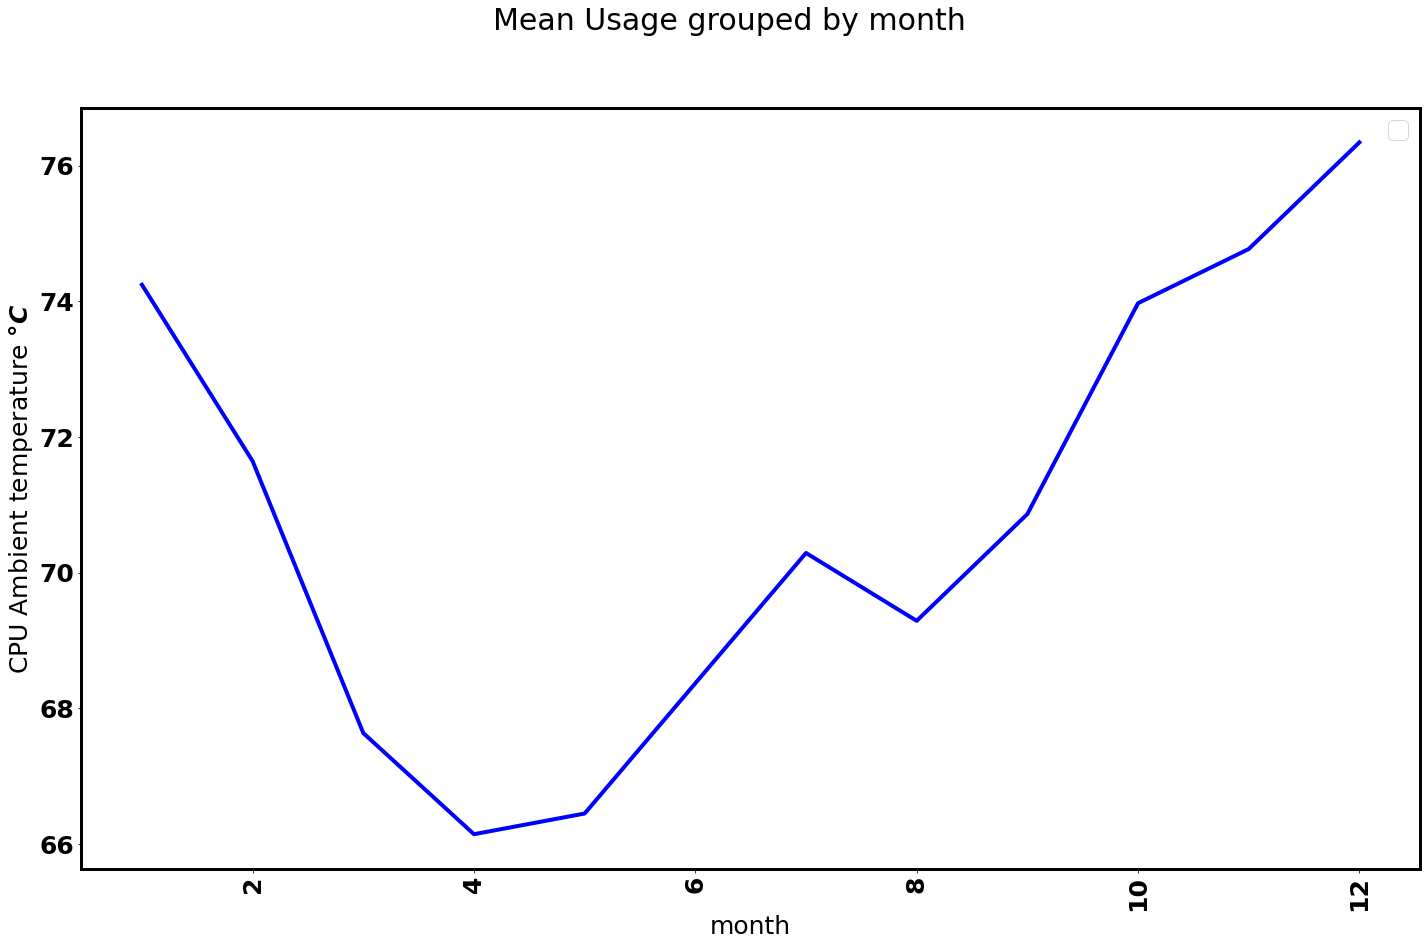

In [150]:
# By Month:
# Group by hours:
# df.groupby('hours').mean()
if True:
    # convert time stamp to numerical data
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    from matplotlib.pylab import rc
    font = {'family': 'normal','weight': 'bold',
            'size': 25}

    matplotlib.rc('font', **font)
    rc('axes', linewidth=3)


    # plot the data using Celcius
    #df.plot(x='timestamp', y='value')

    plt.plot(df.groupby('month').mean().index,df.groupby('month').mean()["value"],"b",linewidth=4,markersize=5)

    plt.xlabel("month")
    plt.ylabel(r"CPU Ambient temperature $\degree C$")
    plt.suptitle("Mean Usage grouped by month")
    plt.xticks(rotation=90)
    fig = matplotlib.pyplot.gcf()


    fig.set_size_inches(24,14)
    plt.legend()

    save_path = plot_path + "Original_group_by_month" + ".png"

    fig.savefig(save_path, dpi=300)






0    7049
1     218
Name: anomaly_iforest, dtype: int64


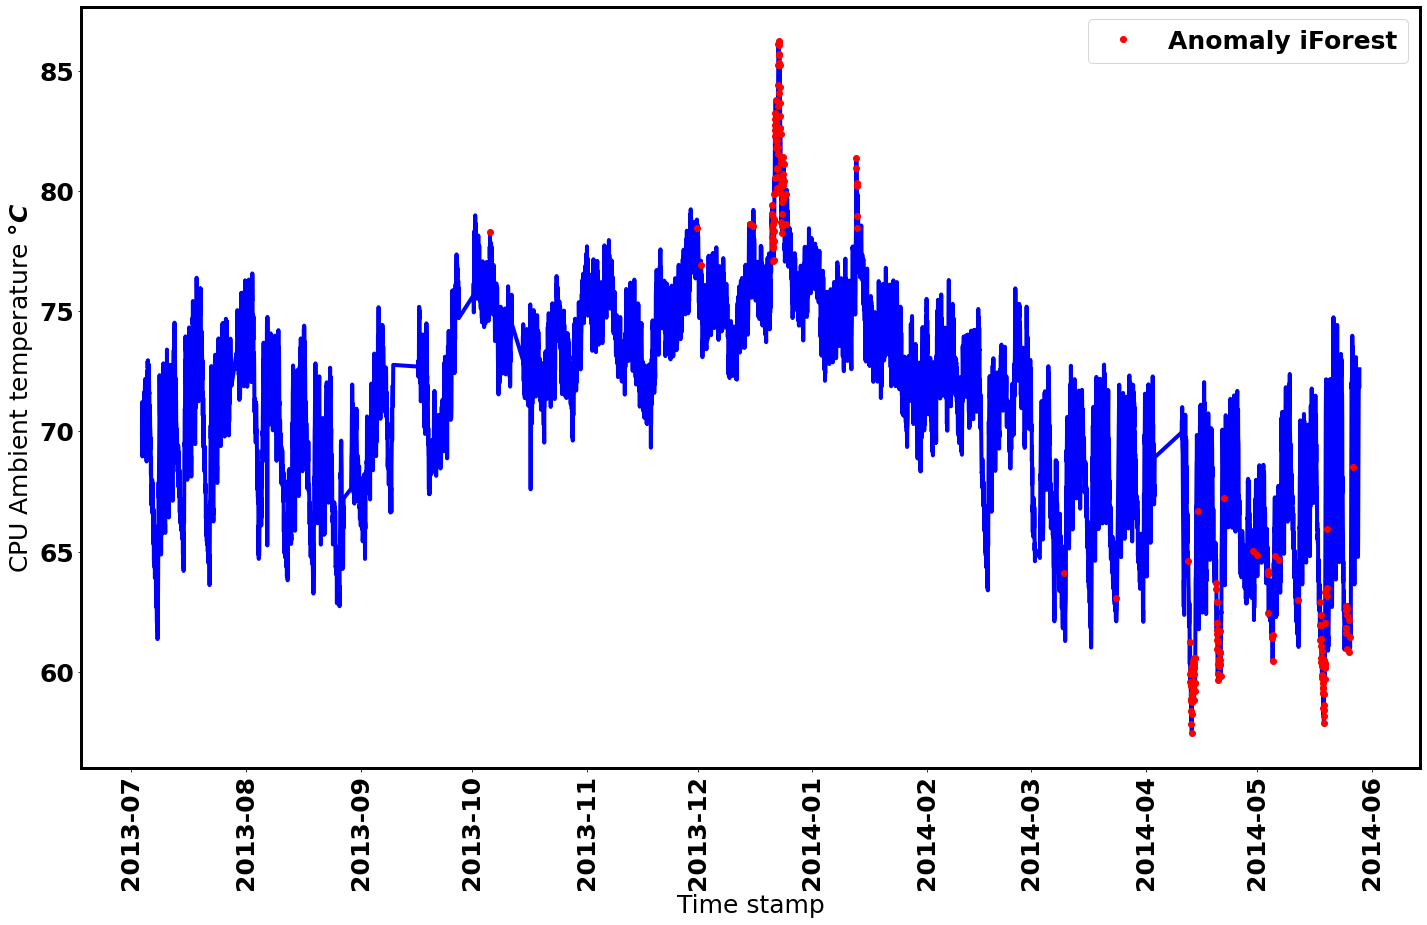

In [133]:
# Baseline: Isolation forest:

outliers_fraction=0.03

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay','open', 'close', 'low', 'high']]
min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(data)

data = pd.DataFrame(np_scaled)

# train Iforest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly_iforest'] = pd.Series(model.predict(data))
df['anomaly_iforest'] = df['anomaly_iforest'].map( {1: 0, -1: 1} )
print(df['anomaly_iforest'].value_counts())


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


mask = df['anomaly_iforest']==1

plt.plot(df['timestamp'],df['value'],"b",linewidth=4)

plt.plot(df[mask]['timestamp'],df[mask]['value'],"ro",linewidth=4,label="Anomaly iForest")

plt.xlabel("Time stamp")
plt.ylabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,14)
plt.legend()

save_path = plot_path + "iForest_v2" + ".png"

fig.savefig(save_path, dpi=300)